## Import standard libraries

In [1]:
import torch
import torch.nn as nn  # we'll use this a lot going forward!
import torch.nn.functional as F

import numpy as np
import warnings

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import pyplot as plt, rc

# Import json library and create function to format dictionaries.
import json
format_json = lambda x: json.dumps(x, indent=4)

# Import pandas and set pandas DataFrame visualization parameters
from IPython.display import display
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Set rendering parameters to use TeX font if not working on Juno app.
from pathlib import Path
import os
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)


Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


## Import user defined libraries

In [2]:
# Import custom libraries from local folder.
import sys
sys.path.append("..")

from library.irplib import utils, eda, config, sdg
from library.irplib import rnn

## Data preparation

### Import training dataset

In [3]:
# Import transformed training dataset
df = eda.import_cdm_data(os.path.join(cwd,'data','esa-challenge','train_data_transformed.csv'))

# Count number of CDMs available per event
nb_cdms = df.groupby(['event_id']).count()['time_to_tca'].to_numpy(dtype=np.int16)

# Define window size and number of events to forecast
window_size = 5
events_to_forecast = 1
min_cdms = window_size + events_to_forecast

print(f'Events suitable for training (More than {min_cdms-1} CDMs): {np.sum(nb_cdms>=min_cdms)}'
      f' ({np.sum(nb_cdms>=min_cdms)/len(nb_cdms)*100:5.1f}%)')
print(f'Time sequences with event_id integrity per feature: {np.sum(nb_cdms[nb_cdms>=min_cdms]-min_cdms)}')

# Count number of CDMs per event
ts_events  = df[['event_id', 'time_to_tca']].groupby(['event_id']).count().rename(columns={'time_to_tca':'nb_cdms'})

# Get events that have a minimum number of CDMs equal to the window_size + events_to_forecast
events_filter = list(ts_events[ts_events['nb_cdms']>=min_cdms].index.values)

# Redefine DataFrame to contain only events suitable for TSF to save memory
df = df[df['event_id'].isin(events_filter)]

# Show first data points to explore data types
display(df.head(10))
df.info()

Events suitable for training (More than 5 CDMs): 9400 ( 71.5%)
Time sequences with event_id integrity per feature: 94699


,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
9,2,6.983474,2,-10.816161,-6.601713,13.293159,22902.0,14348.0,-1157.6,-6306.2,21986.3,15.8,-13792.0,-3957.1,1.0,0.0,3.92,3.92,444,442,99.4,1.094,3.4505,3.042086,0.924980,-10.894082,7158.394530,0.000860,98.523094,-0.099768,0.357995,-0.122174,0.085472,-0.999674,0.121504,-0.999114,0.057809,-0.353866,-0.043471,-0.025138,0.087954,-0.430583,-0.088821,0.021409,UNKNOWN,180.0,2.0,13.87,13.87,15,15,100.0,1.838,NaN,1.579769,2.227246,-7.228422,7168.396928,0.001367,69.717278,-0.068526,0.636970,-0.038214,0.064305,-0.999989,0.036762,-0.996314,0.153806,-0.634961,-0.149627,0.715984,-0.159057,0.953945,0.156803,-0.723349,12.0,2.0,786.417082,774.097978,800.056782,780.463075,63.955771,-16.008858,-0.063092,115.208802,15.229084,42.445608,2.201549,5.549886,4.994608,10.549895,0.496310,5.385613,-1.875151,3.681239,-4.670266,-1.309462,-5.550399,-1.080559,73,77,27,4
10,2,6.691611,2,-10.850473,-6.603452,13.374242,22966.0,14348.0,-1161.1,-6330.2,22046.3,15.8,-13792.0,-3957.1,1.0,0.0,3.86,3.86,444,442,99.4,1.099,3.4505,2.880922,1.065057,-10.960651,7158.394561,0.000861,98.523097,-0.005874,0.360471,-0.036075,-0.002789,-0.999876,0.035870,-0.997255,-0.068114,-0.357012,0.076754,-0.027154,0.084268,-0.442266,-0.085037,0.020991,UNKNOWN,180.0,2.0,13.87,13.87,15,15,100.0,1.838,NaN,1.579769,2.227246,-7.228422,7168.397641,0.001367,69.717278,-0.067750,0.636974,-0.038143,0.063521,-0.999989,0.036689,-0.996313,0.153053,-0.634998,-0.148865,0.715914,-0.158753,0.953971,0.156495,-0.723302,12.0,2.0,786.420510,774.094612,800.057080,780.464203,63.956674,-16.008858,-0.063092,101.429474,16.265328,42.441549,2.196657,5.549796,5.490139,10.547926,0.516145,5.385589,-1.378157,3.679266,-4.669890,-1.309606,-5.536811,-1.080597,73,77,27,4
11,2,6.269979,2,-30.000000,-6.217958,426.808532,18785.0,14347.0,-698.8,-5176.4,18044.8,14.4,-13791.4,-3957.2,1.0,0.0,3.85,3.85,447,445,99.4,1.113,3.4505,2.746222,0.965072,-11.022029,7158.407962,0.000862,98.523100,-0.222621,0.425875,-0.149746,0.206756,-0.999517,0.147289,-0.999479,0.191052,-0.423717,-0.175085,0.082662,0.017007,-0.405439,-0.018617,-0.083820,UNKNOWN,1.0,0.0,14.63,14.63,15,15,100.0,1.641,NaN,1.649021,1.879016,-7.247312,7168.395887,0.001297,69.718437,0.025977,0.563595,0.065183,-0.045196,-0.999602,-0.075887,-0.999774,-0.006036,-0.564147,0.025308,0.703561,-0.027022,0.916588,0.007301,-0.706289,12.0,2.0,786.439755,774.102169,799.554662,780.963112,63.903391,-16.009902,-0.057504,177.272242,15.145344,31.967553,2.295355,3.879431,4.803485,7.832651,0.601252,4.465008,-2.064897,0.961933,-4.579886,-2.987280,-5.530733,-1.644409,71,77,23,8
12,2,6.042352,2,-30.000000,-6.271078,181.496778,18842.0,14347.0,-700.0,-5192.1,18099.4,14.4,-13791.4,-3957.2,1.0,0.0,3.83,3.83,451,449,99.4,

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151099 entries, 9 to 162633
Columns: 103 entries, event_id to AP
dtypes: category(7), float64(88), int16(8)
memory usage: 106.7 MB


## Time-Series Forecasting problem

### Converting data from Pandas DataFrame to Pytorch Tensors

In [4]:
from tqdm import tqdm
from tqdm import trange

# Get input variable features from config file.
in_var_features = list(config.get_features(**{'input':True, 'variable':True}).keys())
in_features     = list(config.get_features(**{'input':True}).keys())

# Get time-series sets for every continuous variable feature 
# (constant features by definition do not need to be forecasted)
tensor_filename = f'training_tsf_ws{window_size}-f{events_to_forecast}.pt'

# Check if file containing tensors is available in the data folder and load it
filepath         = os.path.join(cwd,'data','tensors', tensor_filename)
features_tensors = torch.load(filepath) if os.path.exists(filepath) else {}

in_var_features = ['t_cr_area_over_mass', 't_sedr', 't_ct_r', 't_cn_r',
                      't_cn_t', 't_crdot_r', 't_crdot_t', 't_crdot_n']

# Get all input features from which the tensors have not been extracted yet.
remaining_features = [f for f in in_var_features if not f in list(features_tensors.keys())]


print(f'Features already available in tensor file: {len(list(features_tensors.keys()))}')

# Iterate over all remaining features to get the time series subsets
t = trange(len(remaining_features), desc='Extracting sequences of time-series ...', leave=True)

for f in t:

    # Initialize list of tensors for feature f
    feature = remaining_features[f]
    features_tensors[feature] = []

    for e, event_id in enumerate(events_filter):

        # Update progress bar
        tqdm_desc = f'Extracting sequences of time-series from {feature} {"."*(30-len(feature))} (Progress: {(e+1)/len(events_filter)*100:5.1f}%)'
        t.set_description(tqdm_desc)
        t.refresh()

        # Get full sequence from dataset and convert it to a tensor.
        feature_dtype = str(df[df['event_id']==event_id][feature].dtype).lower()
        full_seq = df[df['event_id']==event_id][feature].to_numpy(dtype=feature_dtype)
        full_seq = torch.nan_to_num(torch.FloatTensor(full_seq))

        # Add Time-Series subsets from full sequence tensor and add it to the list for the feature f
        features_tensors[feature] = features_tensors[feature] + rnn.event_ts_sets(full_seq, window_size)

    if (f+1)%10==0 or (f+1==len(remaining_features)):
        # Save tensors containing all Time-Series subsets for training organised by feature.
        t.set_description(f'Saving tensors with sequences of time-series into external file {"."*(len(tqdm_desc)-64)}')
        t.refresh()
        torch.save(features_tensors, filepath)

Features already available in tensor file: 8


Extracting sequences of time-series ...: 0it [00:00, ?it/s]


#### Embedding categorical input features

An embedding is a vector representation of a categorical variable. The representation of this vector is computed through the use of NN models/techniques that take into account potential relation between categories in order to create the vector representation for each category.

In practice, an embedding matrix is a lookup table for a vector. Each row of an embedding matrix is a vector for a unique category.

The main advantadge of using embeddings instead of One Hot/Dummy Encoding techniques (one column per unique value of categorical feature with 0s and 1s) is that it can preserve the natural order and common relationships between the categorical features. For example, we could represent the days of the week with 4 floating-point numbers each, and two consecutive days would look more similar than two weekdays that are days apart from each other.


The rule of thumb for determining the embedding size (number of elemens per array) is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [5]:
class EventPropagation(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,out_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,hidden_size),
                       torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        # Get output from LSTM layer and the h0 c0 values updated (passed through LSTM)
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)

        # Predict next values with the Linear layer
        pred = self.linear(lstm_out.view(len(seq),-1))

        # Return only last value
        return pred[-1]



In [6]:
# Define Multivariate LSTM network class
class EventPropagation(nn.Module):
    def __init__(self,input_size, hidden_size, output_size, seq_length, num_layers=1):
        super(EventPropagation, self).__init__()
        self.input_size = input_size    # Number of input features
        self.hidden_size = hidden_size  # Number of hidden neurons
        self.output_size = output_size  # Number of outputs
        self.num_layers = num_layers    # Number of recurrent (stacked) layers
        self.seq_length = seq_length
    
        self.lstm = nn.LSTM(input_size = self.input_size, 
                            hidden_size = self.hidden_size,
                            num_layers = self.num_layers,
                            batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.linear = nn.Linear(self.hidden_size*self.seq_length, 
                                self.output_size)
        
    
    def init_hidden(self, n_sequences):
        # Initialize states. Even with batch_first = True this remains same as docs
        h_state = torch.zeros(self.num_layers, n_sequences, self.hidden_size) # Hidden state
        c_state = torch.zeros(self.num_layers, n_sequences, self.hidden_size) # Cell state
        self.hidden = (h_state, c_state)
    
    
    def forward(self, inputs):        
        n_sequences, seq_length, n_features = inputs.size()
        
        lstm_out, self.hidden = self.lstm(inputs, self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        inputs = lstm_out.contiguous().view(n_sequences,-1)
        outputs = self.linear(inputs)
        
        return outputs

In [7]:
# Get list of features and number of sequences to process from tensor file
features    = list(features_tensors.keys())
n_sequences = len(features_tensors[features[0]])
seq_length  = 5 # Window size for the TSF

# Initialize inputs and outputs arrays to contain sequences to process
inputs =  torch.empty((n_sequences,seq_length, len(features)), dtype=torch.float32)
outputs = torch.empty((n_sequences,len(features)), dtype=torch.float32)

# Initialize trange object for sequences to print progress bar.
sequences = trange(n_sequences, desc='Getting training and target tensors ...', leave=True)
for s in sequences:

    # Initialize list for sequence s
    inputs_s    = torch.empty((len(features),seq_length), dtype=torch.float32)
    outputs_s   = torch.empty((len(features),1), dtype=torch.float32)
    # Get sequence s from all features
    for f, feature in enumerate(features):
        
        # Get sequence s (input and output) from feature f
        # - inputs_s  = [[f1_t1, f1_t2, ..., f1_tn], [f2_t1, f2_t2, ..., f2_tn], ...]
        # - outputs_s = [[f1_tn+1], [f2_tn+1], ...]
        inputs_s[f], outputs_s[f] = features_tensors[feature][s]

    # Update progress bar
    sequences.refresh()


    # Get sequence s (input and output) from feature f
    # - inputs  = [[f1_t1, f2_t1, ..., fn_t1], [f1_t2, f2_t2, ..., fn_t2], ...]
    # - outputs = [[f1_tn+1, f2_tn+1, ...], ...]
    inputs[s,:] =  torch.transpose(inputs_s, 0, 1)
    outputs[s,:] = torch.transpose(outputs_s, 0, 1)


Getting training and target tensors ...: 100%|██████████| 104099/104099 [01:16<00:00, 1367.52it/s]


In [11]:
# Instanciate model with required inputs.
torch.manual_seed(42)
model = EventPropagation(input_size = len(features), 
                         hidden_size = 100,
                         output_size = len(features),
                         seq_length = seq_length)

# Define criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

# Print model
model

EventPropagation(
  (lstm): LSTM(8, 100, batch_first=True)
  (linear): Linear(in_features=500, out_features=8, bias=True)
)

In [12]:
import time
start_time = time.time()

# model.train()

epochs = 200
batch_size = 10000

# Initialize array of inf values for losses
losses = np.ones(epochs)*np.inf

# Iterate over all remaining features to get the time series subsets
t = trange(epochs, desc='Extracting sequences of time-series ...', leave=True)

for e in t:
    
    # Train model by passing n batches depending on the batch_size
    batches = range(0, n_sequences, batch_size)
    batch_losses = np.ones(len(batches))*np.inf
    for b, batch in enumerate(batches):
        
        # Get inputs and outputs for batch b
        upper_limit = batch+batch_size if batch+batch_size<n_sequences else n_sequences
        inputs_b  = inputs[batch:upper_limit]
        outputs_b = outputs[batch:upper_limit]  
        
        # Reset Gradient from the optimizer (hidden and cell states)
        optimizer.zero_grad()
        
        # Initialize hidden state and compute outputs
        model.init_hidden(inputs_b.size(0))
        forecast = model(inputs_b) 
        
        # Compute loss using the outputs for the batch b and store values in array
        loss = criterion(forecast, outputs_b)  
        batch_losses[b] = loss.detach().numpy()
        
        # Back propagate loss and adjust parameters of the optimizer
        loss.backward()
        optimizer.step()

    losses[e] = batch_losses[-1]

    # Update progress bar
    t.set_description(f'Training Conjunction Event Propagation model | MSE loss = {losses[e]:10.8f} ')
    t.refresh()
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Training Conjunction Event Propagation model | MSE loss = 0.12230139 : 100%|██████████| 200/200 [04:21<00:00,  1.31s/it]


Duration: 261 seconds


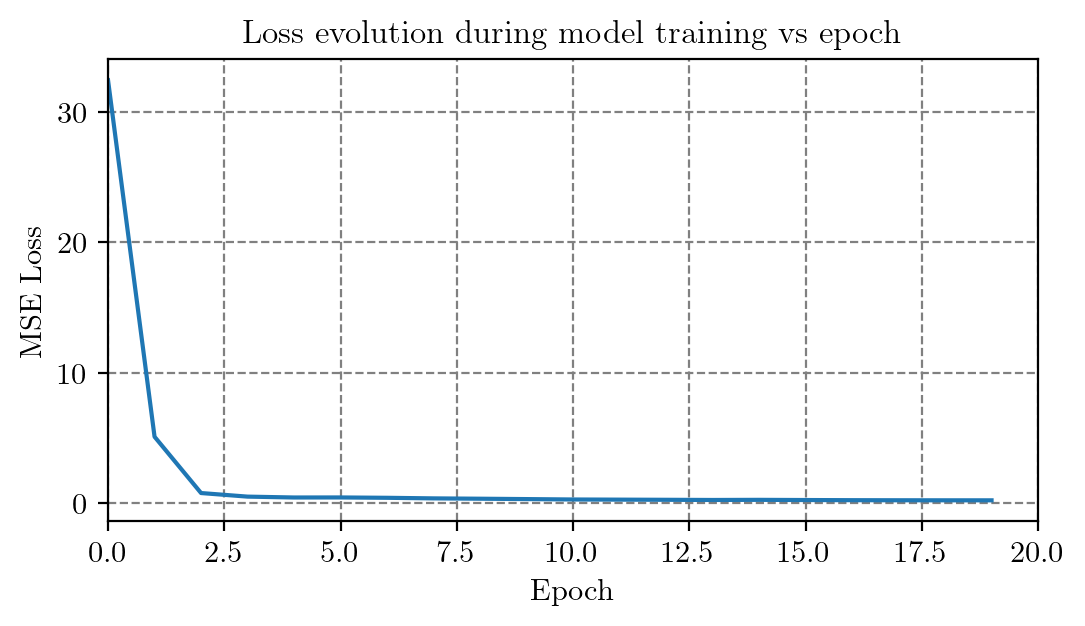

In [16]:
# Plot loss evolution during training
plt.figure(figsize=(6,3))
plt.title(r'Loss evolution during model training vs epoch', fontsize=12)
plt.plot(range(0,20), losses[:20])
plt.xlim(0, 20)
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.grid(True, linestyle='--', c='grey')
plt.show()


## Save the trained model to a file
Right now <strong><tt>model</tt></strong> has been trained and validated, and seems to correctly classify an iris 97% of the time. Let's save this to disk.<br>
The tools we'll use are <a href='https://pytorch.org/docs/stable/torch.html#torch.save'><strong><tt>torch.save()</tt></strong></a> and <a href='https://pytorch.org/docs/stable/torch.html#torch.load'><strong><tt>torch.load()</tt></strong></a><br>

There are two basic ways to save a model.<br>

The first saves/loads the `state_dict` (learned parameters) of the model, but not the model class. The syntax follows:<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model.state_dict(), PATH)<br><br>
<strong>Load:</strong>&nbsp;model = TheModelClass(\*args, \*\*kwargs)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.load_state_dict(torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

The second saves the entire model including its class and parameters as a pickle file. Care must be taken if you want to load this into another notebook to make sure all the target data is brought in properly.<br>
<tt><strong>Save:</strong>&nbsp;torch.save(model, PATH)<br><br>
<strong>Load:</strong>&nbsp;model = torch.load(PATH))<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;model.eval()</tt>

In either method, you must call <tt>model.eval()</tt> to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

For more information visit https://pytorch.org/tutorials/beginner/saving_loading_models.html